# Final Predictions and Viewing

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import skimage.io
from PIL import ImageDraw, Image as Img
from shapely import wkt
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../src'))
sys.path.append(os.path.join(os.getcwd(), '../src/utilities'))
sys.path.append(os.path.join(os.getcwd(), '../xview2-baseline'))

from Model.helper import *
import inference
import process_data_inference
import damage_inference
import utils.combine_jsons as combine_jsons
import utils.inference_image_output as inf_output

from segmentation_cpu import SegmentationModel as Model

import urllib.request as req
import os

import scoring
from get_prediction import get_mask, get_mask_baseline
from src import MODELS_PATH, ROOT_PATH

RESULTS_PATH = ROOT_PATH + "/results/View/"
classification_model = MODELS_PATH + "/downloaded_full_baseline/classification.hdf5"

Using TensorFlow backend.


In [2]:
def view_results(images, titles):
    size = len(images)
    fig, ax = plt.subplots(1, size, figsize=(5*size, 5))
    if(size == 1):
        ax.imshow(images[0])
        ax.set_title(titles[0])
        ax.axis('off')
    else:
        for i, image in enumerate(images): 
            ax[i].imshow(image)
            ax[i].set_title(titles[i])
            ax[i].axis('off')
        
    plt.show()

In [3]:
def get_polygons_from_label(path_to_label_value):
    # Opening and loading polygons from label json
    # Return the list of polygons
    with open(path_to_label_value, 'rb') as image_json_file:
        image_json = json.load(image_json_file)

    coords = image_json['features']['xy']
    wkt_polygons = []

    for coord in coords:
        if 'subtype' in coord['properties']:
            damage = coord['properties']['subtype']
        else:
            damage = 'no-damage'
        wkt_polygons.append((damage, coord['wkt']))

    polygons = []

    for damage, swkt in wkt_polygons:
        polygons.append((damage, wkt.loads(swkt)))

    return polygons
def load_image_with_polygons(img, path_to_polygons_json):
    if os.path.isfile(img): 
        img = Img.open(img)
    else:    
        img_path = tmp_path + 'temp_image.png'
        req.urlretrieve(img,img_path)
        img = Img.open(img_path)
    polygons = get_polygons_from_label(path_to_polygons_json)
    img = img.resize((254,254))
    draw = ImageDraw.Draw(img, 'RGBA')

    damage_dict = {
        "no-damage": (0, 255, 0, 100),
        "minor-damage": (0, 0, 255, 125),
        "major-damage": (255, 69, 0, 125),
        "destroyed": (255, 0, 0, 125),
        "un-classified": (255, 255, 255, 125)
    }
    for damage, polygon in polygons:
        x,y = polygon.exterior.coords.xy
        coords = list(zip(x,y))
        draw.polygon(coords, damage_dict[damage])

    del draw

    return img

# Out of Domain Predictions

In [4]:
urls = [
  'https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png',
  'https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png',
  'https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png',
  'https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png',
  'https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png',
  'https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png'
]

/home/ubuntu/disaster-relief-satellite/env/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 11 validated image filenames.
1/1 [==============================] - 2s 2s/step


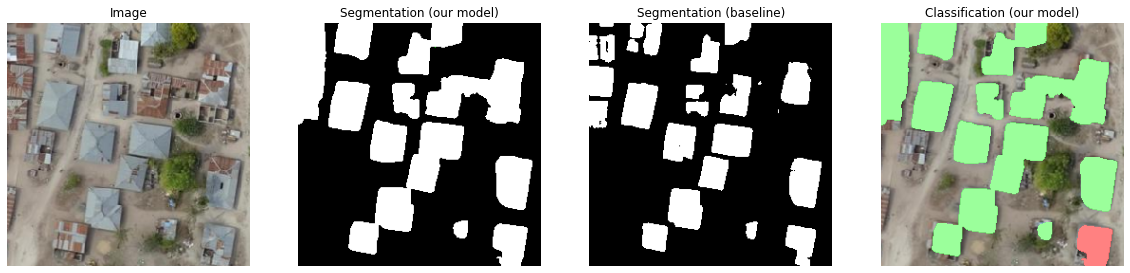

Found 9 validated image filenames.
1/1 [==============================] - 2s 2s/step


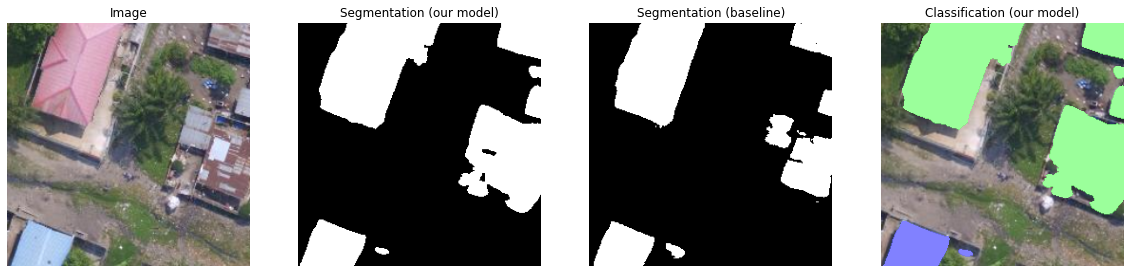

Found 16 validated image filenames.
1/1 [==============================] - 2s 2s/step


Found 21 validated image filenames.
1/1 [==============================] - 2s 2s/step


Found 4 validated image filenames.
1/1 [==============================] - 2s 2s/step


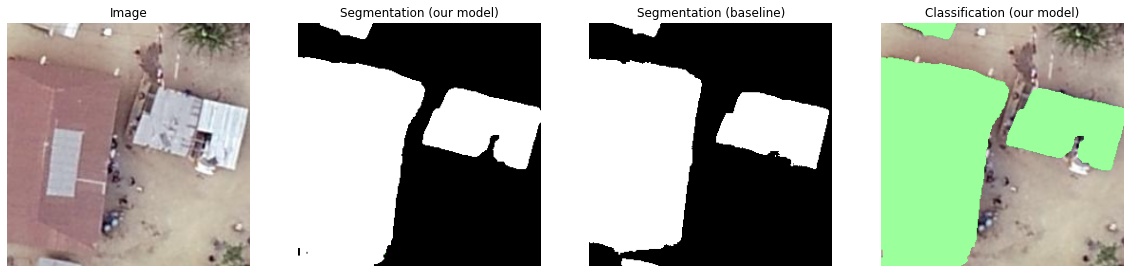

Found 8 validated image filenames.
1/1 [==============================] - 2s 2s/step


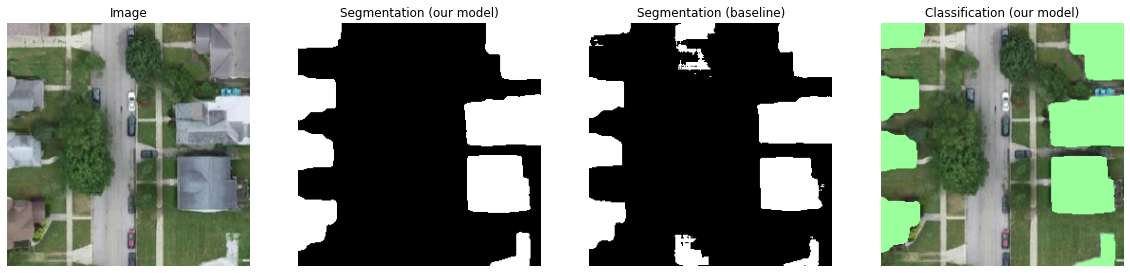

In [5]:
# %tb
if(os.path.isdir(RESULTS_PATH)):
    shutil.rmtree(RESULTS_PATH)
for index, url in enumerate(urls):
    img = skimage.io.imread(url)
    segmented_img = get_mask(img)
    seg_img_bs = get_mask_baseline(img)

    
    json_file =  RESULTS_PATH + str(index) + ".json"
    polygons_file = RESULTS_PATH + str(index) + ".csv"
    poly_images_path = RESULTS_PATH + "Poly Images/"
    damage_json_file = RESULTS_PATH + "tmp/inf_" + str(index) + ".json"
    tmp_path = RESULTS_PATH + "tmp/"
    damage_combined_json_file = RESULTS_PATH + "tmp/combined_inf_" + str(index) + ".json"
    output_file =  RESULTS_PATH + "output_" + str(index) + ".png"
    
    if not os.path.isdir(poly_images_path):
        os.makedirs(poly_images_path)
        os.makedirs(tmp_path)
        
    inference.inference(img, segmented_img, json_file)

    
    process_data_inference.process_img_poly(img, json_file, poly_images_path, polygons_file)
    damage_inference.run_inference(poly_images_path, polygons_file, classification_model, damage_json_file)
    combine_jsons.combine_output(json_file, damage_json_file, damage_combined_json_file)
    inf_output.create_inference_image(damage_combined_json_file, output_file)
    


    final_img = load_image_with_polygons(url, damage_combined_json_file)
    images = [img, segmented_img, seg_img_bs, final_img]
    titles = ["Image","Segmentation (our model)", "Segmentation (baseline)", "Classification (our model)"]
    view_results(images, titles)


# Scoring

In [7]:
# Scoring from both segmentation model and classification model
scoring.main()


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating the score!



100%|██████████| 100/100 [04:42<00:00,  2.82s/it]


Segmentation Model:
Dice:
our model: 0.1507123537114837
baseline model: 0.13064965445235088


IoU:
our model: 0.15035859024104611
baseline model: 0.13032725730980507


Calculating the score!
Classification Model:
F1:
our model: 0.888
baseline model: 0.612


